In [1]:
import os
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter, MaxNLocator, LogLocator 
from matplotlib import transforms
from datasets import load_dataset, get_dataset_split_names, DatasetDict
from tqdm import tqdm
tqdm.pandas()

sns.set_color_codes("colorblind")
sns.set_theme(style="white")
sns.set_context("talk")
# sns.color_palette()
sns.color_palette("tab10")

# set font to times new roman for plots
sns.set_style({'font.family':'serif', 'font.serif':'Times New Roman'})

/Users/kyle/miniconda3/envs/memorization/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load Datasets

In [2]:
split_sample_size = None
label_title_padding = 10
study_pile = False
RECITATION_THRESHOLD = 5

figures_path = f"scale+time_figures/recitation_threshold_{RECITATION_THRESHOLD}/"
if not os.path.exists(figures_path):
    os.makedirs(figures_path)

In [3]:
memories_path = "usvsnsp/generation-semantic-filters"
intermediate_path = "usvsnsp/generation-semantic-intermediate-filters"
memories_dataset = DatasetDict()
pile_dataset = DatasetDict()
splits = [split for split in get_dataset_split_names(memories_path) if "deduped" in split] + get_dataset_split_names(intermediate_path)
splits = [split for split in splits if "deduped" in split]
print(splits)

['pile_deduped_1.4b', 'memories_deduped_410m', 'memories_deduped_1.4b', 'memories_deduped_6.9b', 'memories_deduped_1b', 'pile_deduped_410m', 'pile_deduped_2.8b', 'pile_deduped_160m', 'pile_deduped_6.9b', 'pile_deduped_1b', 'memories_deduped_70m', 'memories_deduped_2.8b', 'pile_deduped_12b', 'memories_deduped_160m', 'pile_deduped_70m', 'memories_deduped_12b', 'memories_deduped_12b.43000', 'memories_deduped_12b.103000', 'memories_deduped_12b.83000', 'memories_deduped_12b.63000', 'memories_deduped_12b.123000', 'memories_deduped_12b.23000']


In [4]:
print("Loading datasets...")
print(f"Split sample size: {split_sample_size}")

for split in tqdm(splits):
    model = split.split("_")[-1]
    checkpoint = int(split.split(".")[-1]) if split.split(".")[-1][1].isnumeric() else 143000
    formatted_split_name = split.replace("memories_", "").replace("deduped_", "deduped.").replace("pile_", "")
    dataset_path = memories_path if checkpoint == 143000 else intermediate_path
    if "memories" in split: 
        # continue # Don't load memories since they're unnecessary for the first part of the analysis
        memories_dataset[formatted_split_name] = load_dataset(dataset_path, split=f"{split}[:{split_sample_size}]" if split_sample_size else split)
    else:
        # continue
        pile_dataset[formatted_split_name] = load_dataset(dataset_path, split=f"{split}[:{split_sample_size}]" if split_sample_size else split)

display(memories_dataset)
display(pile_dataset)

Loading datasets...
Split sample size: None


100%|██████████| 22/22 [08:11<00:00, 22.32s/it]


DatasetDict({
    deduped.410m: Dataset({
        features: ['sequence_id', 'tokens', 'text', 'is_incrementing', 'is_repeating', 'sequence_duplicates', 'max_frequency', 'avg_frequency', 'min_frequency', 'median_frequency', 'p25_frequency', 'p75_frequency', 'frequencies', 'nl_scores', '0_8_snowclones', '0_9_snowclones', '0_8_templates', '0_9_templates', 'huffman_coding_length', 'memorization_score', 'index', 'loss', 'prompt_perplexity', 'generation_perplexity', 'sequence_perplexity'],
        num_rows: 811040
    })
    deduped.1.4b: Dataset({
        features: ['sequence_id', 'tokens', 'text', 'is_incrementing', 'is_repeating', 'sequence_duplicates', 'max_frequency', 'avg_frequency', 'min_frequency', 'median_frequency', 'p25_frequency', 'p75_frequency', 'frequencies', 'nl_scores', '0_8_snowclones', '0_9_snowclones', '0_8_templates', '0_9_templates', 'huffman_coding_length', 'memorization_score', 'index', 'loss', 'prompt_perplexity', 'generation_perplexity', 'sequence_perplexity'],
    

DatasetDict({
    deduped.1.4b: Dataset({
        features: ['sequence_id', 'tokens', 'text', 'is_incrementing', 'is_repeating', 'sequence_duplicates', 'max_frequency', 'avg_frequency', 'min_frequency', 'median_frequency', 'p25_frequency', 'p75_frequency', 'frequencies', 'nl_scores', '0_8_snowclones', '0_9_snowclones', '0_8_templates', '0_9_templates', 'huffman_coding_length', 'memorization_score', 'index', 'loss', 'prompt_perplexity', 'generation_perplexity', 'sequence_perplexity'],
        num_rows: 5000000
    })
    deduped.410m: Dataset({
        features: ['sequence_id', 'tokens', 'text', 'is_incrementing', 'is_repeating', 'sequence_duplicates', 'max_frequency', 'avg_frequency', 'min_frequency', 'median_frequency', 'p25_frequency', 'p75_frequency', 'frequencies', 'nl_scores', '0_8_snowclones', '0_9_snowclones', '0_8_templates', '0_9_templates', 'huffman_coding_length', 'memorization_score', 'index', 'loss', 'prompt_perplexity', 'generation_perplexity', 'sequence_perplexity'],
   

In [5]:
split_to_param_count = {
    "70m": 70000000,
    "410m": 410000000,
    "160m": 160000000,
    "1b": 1000000000,
    "1.4b": 1400000000,
    "2.8b": 2800000000,
    "6.9b": 6900000000,
    "12b": 12000000000,
}

In [6]:
def get_frame_from_split(dataset, split_name, is_pile_sample):
    current_frame = dataset[split].to_pandas()
    current_frame.drop(columns=columns_to_drop, inplace=True)
    checkpoint = int(split.split(".")[-1]) if split.split(".")[-1][1].isnumeric() and len(split.split(".")) != 2 else "Final"
    current_frame["Checkpoint"] = checkpoint
    current_frame["TrainingPercentage"] = 1 if checkpoint == "Final" else checkpoint / 143000
    model = split.split("deduped")[-1][1:] if checkpoint == "Final" else split.split(".")[-2]
    current_frame["Model"] = model
    current_frame["Param Count"] = split_to_param_count[current_frame["Model"].iloc[0]]
    current_frame["Deduped"] = "deduped" in split
    current_frame["Memorized"] = current_frame["memorization_score"] >= 1
    current_frame["IsPileSample"] = is_pile_sample
    return current_frame


columns_to_drop = ["frequencies", "tokens", "text"]
combined_dataframe = None
for split in tqdm(memories_dataset, desc="Loading Memories"):
    current_frame = get_frame_from_split(memories_dataset, split, False)
    if combined_dataframe is None:
        combined_dataframe = current_frame
    else:
        combined_dataframe = pd.concat([combined_dataframe, current_frame])

for split in tqdm(pile_dataset, desc="Loading Pile"):
    current_frame = get_frame_from_split(pile_dataset, split, True)
    combined_dataframe = pd.concat([combined_dataframe, current_frame])

combined_dataframe = combined_dataframe.sort_values("Param Count")
combined_dataframe

Loading Pile: 100%|██████████| 8/8 [02:01<00:00, 15.15s/it]


,sequence_id,is_incrementing,is_repeating,sequence_duplicates,max_frequency,avg_frequency,min_frequency,median_frequency,p25_frequency,p75_frequency,...,prompt_perplexity,generation_perplexity,sequence_perplexity,Checkpoint,TrainingPercentage,Model,Param Count,Deduped,Memorized,IsPileSample
4999999,146403638,False,False,1,10346382453,1.676912e+09,1462435,42754129.0,9112132,1728418100,...,5.739519,9.374301,53.803978,Final,1.00000,70m,70000000,True,False,True
1392363,28389141,False,False,1,11740996961,3.280973e+09,589316,237957196.5,5864365,4201626736,...,12.002856,7.046402,84.576958,Final,1.00000,70m,70000000,True,False,True
1392364,28390708,False,False,1,10346382453,2.100984e+09,708704,487321485.0,15526702,4084327341,...,15.481421,7.782652,120.486526,Final,1.00000,70m,70000000,True,False,True
1392365,28391631,False,False,1,11740996961,1.634204e+09,8442720,471247322.0,106137180,918861018,...,2.313667,1.719604,3.978590,Final,1.00000,70m,70000000,True,False,True
1392366,28402202,False,False,62,11740996961,1.877380e+09,942253,331265808.0,8759840,805411051,...,1.934296,6.144555,11.885390,Final,1.00000,70m,70000000,True,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2273159,9069785,False,False,1,9362638615,4.804305e+08,441680,10474597.5,2093130,47941870,...,4.043283,3.445634,13.931673,Final,1.00000,12b,12000000000,True,False,True
2273160,9074394,False,False,2,10346382453,1.023979e+09,682554,62437106.5,4348851,252804149,...,7.942500,2.781092,22.088825,Final,1.00000,12b,12000000000,True,False,True
2273161,9075271,False,False,2,10346382453,1.945579e+09,513344,38436463.0,9082200,1188287314,...,5.185763,4.454333,23.099115,Final,1.00000,12b,12000000000,True,False,True
2273097,8861887,False,False,1,10346382453,1.749205e+09,513432,88625534.5,3168365,1879045405,...,5.837689,4.160680,24.288754,Final,1.00000,12b,12000000000,True,False,True


In [7]:
combined_dataframe = combined_dataframe[combined_dataframe["Model"] != "160m"]
combined_dataframe.value_counts("Model")

Model
12b     11590265
6.9b     6680296
2.8b     6355216
1.4b     6048104
1b       6032872
410m     5811040
70m      5411448
Name: count, dtype: int64

## Assign Examples to Taxonomy

In [8]:
def get_category(row):
    if row["Memorized"] == False:
        return "Not Memorized"
    if row["sequence_duplicates"] > RECITATION_THRESHOLD:
        return "Recitation"
    if row["is_incrementing"] or row["is_repeating"]:
        return "Reconstruction"

    return "Recollection"

combined_dataframe["category"] = combined_dataframe.progress_apply(lambda row: get_category(row), axis=1)

combined_dataframe.value_counts(["Model", "Checkpoint", "category"])

100%|██████████| 47929241/47929241 [02:22<00:00, 336620.32it/s]
/var/folders/_m/m_v8tmqs05lf3_0frmhh2tkc0000gn/T/ipykernel_60333/1932644100.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_dataframe["category"] = combined_dataframe.progress_apply(lambda row: get_category(row), axis=1)


Model  Checkpoint  category      
70m    Final       Not Memorized     4990571
410m   Final       Not Memorized     4979577
1b     Final       Not Memorized     4973065
1.4b   Final       Not Memorized     4972518
2.8b   Final       Not Memorized     4962857
6.9b   Final       Not Memorized     4952353
12b    Final       Not Memorized     4946005
                   Recitation        1609737
6.9b   Final       Recitation        1454501
12b    123000      Recitation        1308538
2.8b   Final       Recitation        1170922
12b    103000      Recitation         999867
1.4b   Final       Recitation         909486
1b     Final       Recitation         900058
12b    83000       Recitation         710823
410m   Final       Recitation         706964
12b    63000       Recitation         489629
70m    Final       Recitation         370270
12b    43000       Recitation         301146
       Final       Recollection       289471
6.9b   Final       Recollection       248101
12b    123000      Re

## Plot Graphs

### Figure: Count and Memories by Taxonomy Across Time and Scale

In [9]:
combined_memories_dataframe = combined_dataframe[combined_dataframe["IsPileSample"] == False]
combined_memories_dataframe

,sequence_id,is_incrementing,is_repeating,sequence_duplicates,max_frequency,avg_frequency,min_frequency,median_frequency,p25_frequency,p75_frequency,...,generation_perplexity,sequence_perplexity,Checkpoint,TrainingPercentage,Model,Param Count,Deduped,Memorized,IsPileSample,category
388187,105882301,False,False,25689,10346382453,2.390495e+09,394683,71527687.5,8671693,4201626736,...,1.010610,3.476297,Final,1.00000,70m,70000000,True,True,False,Recitation
388186,105822604,False,False,44274,11740996961,1.645153e+09,421963,85759357.0,10195558,816247750,...,1.007740,1.919276,Final,1.00000,70m,70000000,True,True,False,Recitation
388185,105666721,False,False,1496,11740996961,2.435834e+09,614948,10922855.0,1732550,1280820307,...,1.015032,2.045182,Final,1.00000,70m,70000000,True,True,False,Recitation
388184,105645878,False,False,136529,11740996961,2.947588e+09,1488232,318219178.5,8703605,4746582725,...,1.036094,2.237765,Final,1.00000,70m,70000000,True,True,False,Recitation
388183,105609090,False,False,10940,10346382453,1.193023e+09,1207881,56810003.0,10991378,689751572,...,1.038975,3.741002,Final,1.00000,70m,70000000,True,True,False,Recitation
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
876536,43297667,False,False,6,9362638615,1.173040e+09,554933,364376668.0,52218058,1659997854,...,NaN,NaN,103000,0.72028,12b,12000000000,True,True,False,Recitation
876535,43288101,False,False,2,2965935634,5.571220e+08,1941178,86724122.0,14258390,695610999,...,NaN,NaN,103000,0.72028,12b,12000000000,True,True,False,Recollection
876534,43275532,False,False,9948,11740996961,2.056635e+09,1695260,287869575.5,41021079,615893065,...,NaN,NaN,103000,0.72028,12b,12000000000,True,True,False,Recitation
876598,43929568,False,False,4,11740996961,8.455032e+08,1054010,11049698.5,2207127,304221700,...,NaN,NaN,103000,0.72028,12b,12000000000,True,True,False,Recollection


In [10]:
# Create plot for data across 
counts_frame_scale = combined_memories_dataframe[combined_memories_dataframe["Checkpoint"] == "Final"].value_counts(["Param Count", "category"]).unstack().reindex(split_to_param_count.values())
counts_frame_scale.to_csv(f"final_checkpoint_counts_recitation={RECITATION_THRESHOLD}.csv")
display(counts_frame_scale)

intermediate_frame = combined_memories_dataframe[combined_memories_dataframe["Model"] == "12b"]
sorted_checkpoints = sorted(sorted(intermediate_frame["TrainingPercentage"].unique(), key=lambda x: int(x)))

counts_frame_time = intermediate_frame.value_counts(["TrainingPercentage", "category"]).unstack().reindex(sorted_checkpoints)
counts_frame_time.to_csv(f"intermediate_checkpoint_counts_recitation={RECITATION_THRESHOLD}.csv")
display(counts_frame_time)

category,Recitation,Recollection,Reconstruction
Param Count,,,
70000000,362550.0,34738.0,14160.0
410000000,690726.0,99055.0,21259.0
160000000,NaN,NaN,NaN
1000000000,878456.0,132165.0,22251.0
1400000000,887549.0,138939.0,21616.0
2800000000,1141180.0,190157.0,23879.0
6900000000,1416014.0,239799.0,24483.0
12000000000,1566369.0,279736.0,25111.0


category,Recitation,Recollection,Reconstruction
TrainingPercentage,,,
0.160839,137681,22175,3562
0.300699,301146,51098,6619
0.440559,489629,84992,10446
0.580420,710823,127278,13967
0.720280,999867,178000,17711
0.860140,1308538,234022,21495
1.000000,1566369,279736,25111


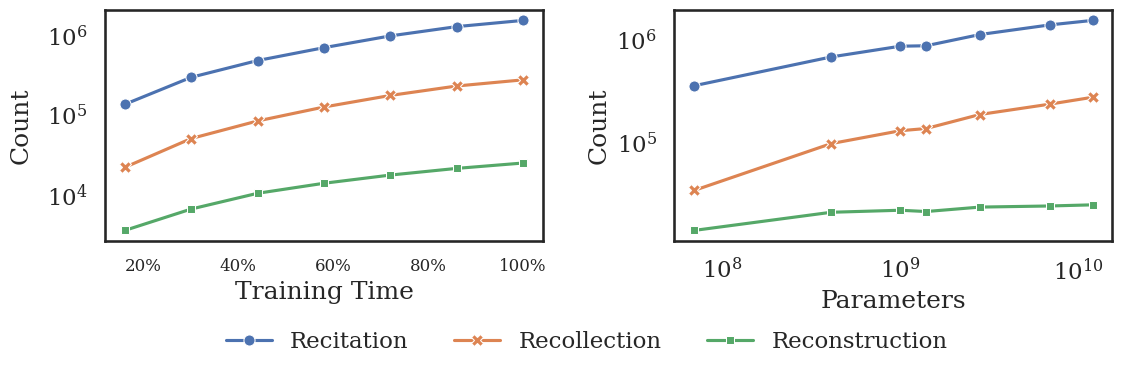

In [11]:
from matplotlib.ticker import PercentFormatter

fig, axes = plt.subplots(1, 2, figsize=(13, 3))

# set figure 1
# first figure is a line plot of the counts of each category for across intermediate checkpoints

sns.lineplot(ax=axes[0], data=counts_frame_time, dashes=False, markers=True, markersize=8)

# rotate x axis labels
# axes[0].tick_params(axis='x', rotation=20)

# Set x axix label to "Training Time"
axes[0].set_xlabel("Training Time")

# make x labels smaller
axes[0].tick_params(axis='x', labelsize=12)

# the x axis values are between 0 and 1. Set the x axis to be a percentage
axes[0].xaxis.set_major_formatter(PercentFormatter(1))

# Add y label for Count
axes[0].set_ylabel("Count", labelpad=label_title_padding)

# add padding for labels
fig.subplots_adjust(wspace=0.2)

# make x and y axis log scale
axes[0].set_yscale("log")

# # have a common legend for both plots centered below the figure. No legend box
axes[0].legend(loc='upper center', bbox_to_anchor=(1.1, -0.3), ncol=4, frameon=False)

# set figure 2
# the second figure is a line plot of the counts of each category across parameter count

sns.lineplot(ax=axes[1], data=counts_frame_scale, dashes=False, markers=True, markersize=8)

# make x and y axis log scale
axes[1].set_xscale("log")
axes[1].set_yscale("log")

# Set x label to "Parameters"
axes[1].set_xlabel("Parameters")

# Add y label for Count
axes[1].set_ylabel("Count")

# remove legend
axes[1].legend().remove()

# add padding for labels
fig.subplots_adjust(wspace=0.30)

fig.savefig(f"{figures_path}/categories_counts_across_time+scale.pdf", bbox_inches="tight")

### Figure: Percents and Memories by Taxonomy Across Time and Scale

In [12]:
counts_frame = combined_memories_dataframe.value_counts(["Param Count", "category"]).unstack().reindex(split_to_param_count.values())
display(counts_frame)

category,Recitation,Recollection,Reconstruction
Param Count,,,
70000000,362550.0,34738.0,14160.0
410000000,690726.0,99055.0,21259.0
160000000,NaN,NaN,NaN
1000000000,878456.0,132165.0,22251.0
1400000000,887549.0,138939.0,21616.0
2800000000,1141180.0,190157.0,23879.0
6900000000,1416014.0,239799.0,24483.0
12000000000,5514053.0,977301.0,98911.0


In [13]:

all_percents_time = []
for checkpoint in tqdm(sorted_checkpoints):
    model_examples = combined_memories_dataframe[combined_memories_dataframe["TrainingPercentage"] == checkpoint]
    model_percents = model_examples.value_counts("category", normalize=True).to_dict()
    for category in model_percents:
        all_percents_time.append({
            "TrainingPercentage": checkpoint,
            "category": category,
            "percent": model_percents[category],
        })

percents_frame_time = pd.DataFrame(all_percents_time).pivot(index="TrainingPercentage", columns="category", values="percent").reindex(sorted_checkpoints)
percents_frame_time.index = [f"{int(percent * 100)}%" for percent in percents_frame_time.index]
percents_frame_time.to_csv(f"percents_frame_time_recitation={RECITATION_THRESHOLD}.csv")
display(percents_frame_time)

100%|██████████| 7/7 [00:01<00:00,  5.78it/s]


category,Recitation,Recollection,Reconstruction
16%,0.842508,0.135695,0.021797
30%,0.839167,0.142389,0.018444
44%,0.836877,0.145269,0.017854
58%,0.834233,0.149375,0.016392
72%,0.836304,0.148882,0.014814
86%,0.836632,0.149625,0.013743
100%,0.845637,0.135757,0.018606


In [14]:
all_percents_scale = []
for param_count in tqdm(split_to_param_count.values()):
    model_examples = combined_memories_dataframe[combined_memories_dataframe["Param Count"] == param_count]
    model_percents = model_examples.value_counts("category", normalize=True).to_dict()
    for category in model_percents:
        all_percents_scale.append({
            "Model": model_examples["Model"].unique()[0],
            "Param Count": param_count,
            "category": category,
            "percent": model_percents[category],
        })

# where Model != 160m
model_keys = [key for key in split_to_param_count.keys() if key != "160m"]
percents_frame_scale = pd.DataFrame(all_percents_scale).pivot(index="Model", columns="category", values="percent").reindex(model_keys)
percents_frame_scale.to_csv(f"percents_frame_scale_recitation={RECITATION_THRESHOLD}.csv")
display(percents_frame_scale)

100%|██████████| 8/8 [00:01<00:00,  4.19it/s]


category,Recitation,Recollection,Reconstruction
Model,,,
70m,0.881156,0.084429,0.034415
410m,0.851655,0.122133,0.026212
1b,0.850498,0.127959,0.021543
1.4b,0.846814,0.132562,0.020624
2.8b,0.842065,0.140315,0.017620
6.9b,0.842717,0.142712,0.014571
12b,0.836697,0.148295,0.015009


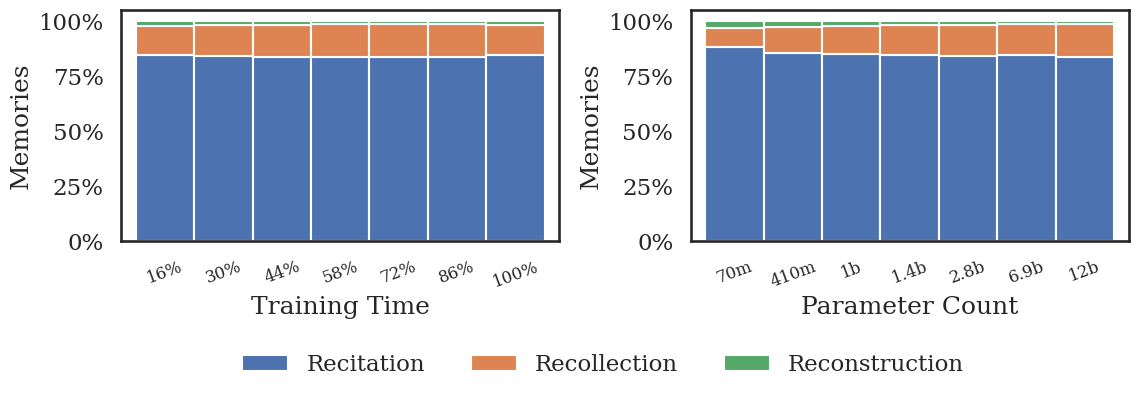

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(13, 3))
plots = [
    (percents_frame_time, axes[0]),
    (percents_frame_scale, axes[1])
]

for idx, (data, ax) in enumerate(plots):
    data.plot.bar(
        stacked=True,
        ax=ax,
        rot=0,
        width=1,
        ylabel="Memories",
    )

    if idx == 0:
        ax.set_xlabel("Training Time")
    else:
        ax.set_xlabel("Parameter Count")
    
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}%".format(int(x * 100))))
    ax.tick_params(axis='x', rotation=20, labelsize=12)
    ax.get_legend().remove()

# Adjusting subplot parameters
fig.subplots_adjust(wspace=0.30)

# Common legend configuration
axes[0].legend(loc='upper center', bbox_to_anchor=(1.1, -0.4), ncol=4, frameon=False)

# align x axis labels
fig.align_xlabels()

# Save the figure
fig.savefig(f"{figures_path}/categories_percents_across_time+scale.pdf", bbox_inches="tight")


## Figure: Combined Counts + Percents Plot

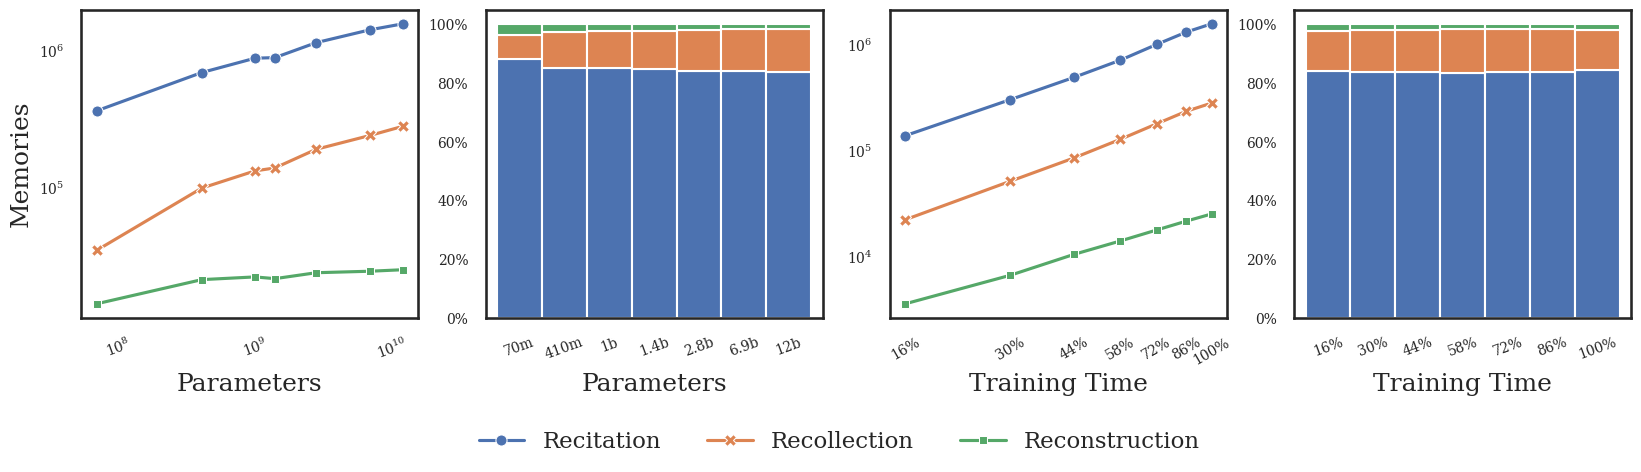

In [16]:
# Single row with four plots. Plot ordering is counts across scale, percents across scale, counts across time, percents across time
fig, axes = plt.subplots(1, 4, figsize=(20, 4))

# set figure 1
sns.lineplot(ax=axes[0], data=counts_frame_scale, dashes=False, markers=True, markersize=8)
axes[0].tick_params(axis='x', rotation=20, labelsize=10)
axes[0].set_yscale("log")
axes[0].set_xscale("log")
axes[0].tick_params(axis='y', labelsize=10)
axes[0].set_ylabel("Memories")
axes[0].set_xlabel("Parameters")
axes[0].legend(loc='upper center', bbox_to_anchor=(2.25, -0.3), ncol=4, frameon=False)

# set figure 2
percents_frame_scale.plot.bar(
    stacked=True,
    ax=axes[1],
    rot=0,
    width=1,
)
axes[1].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}%".format(int(x * 100))))
axes[1].tick_params(axis='x', rotation=20, labelsize=10)
axes[1].tick_params(axis='y', labelsize=10)
axes[1].set_xlabel("Parameters")
axes[1].get_legend().remove()

sns.lineplot(ax=axes[2], data=counts_frame_time, dashes=False, markers=True, markersize=8)
axes[2].set_yscale("log")
axes[2].tick_params(axis='x', labelsize=10)
axes[2].tick_params(axis='y', labelsize=10)
axes[2].set_xscale("log", base=2)
axes[2].set_xticks(sorted_checkpoints)
axes[2].tick_params(axis='x', rotation=30)
axes[2].set_xlabel("Training Time")
axes[2].xaxis.set_major_formatter(PercentFormatter(1))
axes[2].legend().remove()

# set figure 4
percents_frame_time.plot.bar(
    stacked=True,
    ax=axes[3],
    rot=0,
    width=1,
)
axes[3].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}%".format(int(x * 100))))
axes[3].tick_params(axis='x', rotation=20, labelsize=10)
axes[3].tick_params(axis='y', labelsize=10)
axes[3].set_xlabel("Training Time")
axes[3].get_legend().remove()

# make all the x labels have the same height
fig.align_xlabels()

# Save the figure
fig.savefig(f"{figures_path}/categories_counts_percents_across_time+scale.pdf", bbox_inches="tight")

### Same chart but with bounded bar charts

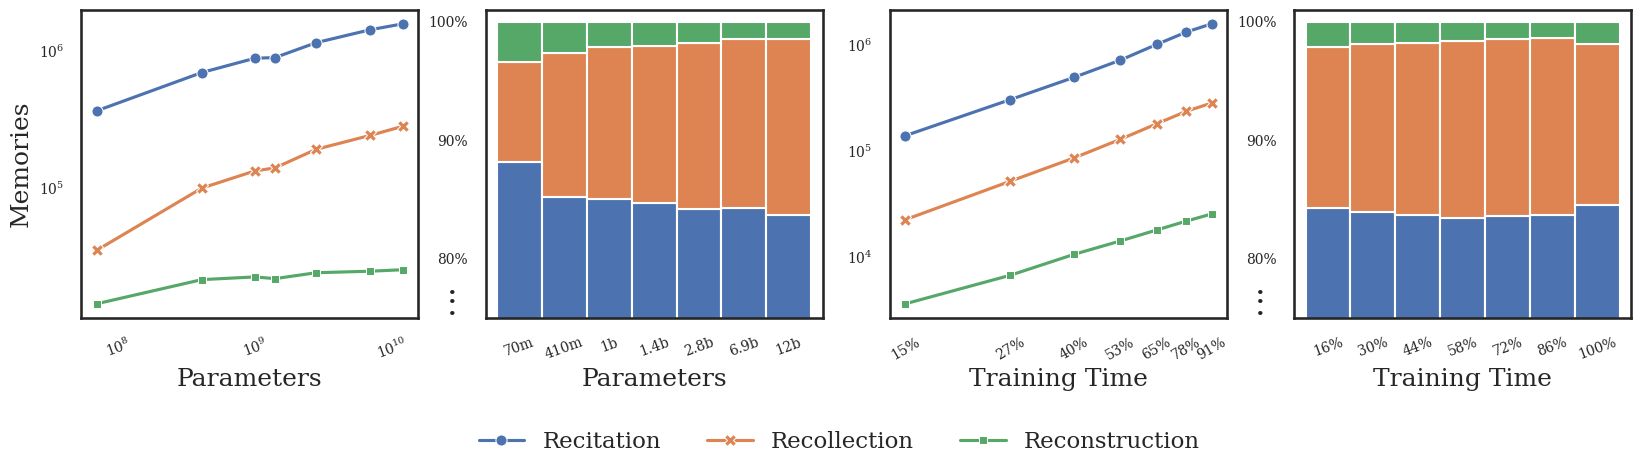

In [17]:
# Single row with four plots. Plot ordering is counts across scale, percents across scale, counts across time, percents across time
fig, axes = plt.subplots(1, 4, figsize=(20, 4))

percents_figure_y_lim = (0.75, 1.01)
percents_figure_y_ticks = [0.8, 0.9, 1]

# set figure 1
sns.lineplot(ax=axes[0], data=counts_frame_scale, dashes=False, markers=True, markersize=8)
axes[0].tick_params(axis='x', rotation=20, labelsize=10)
axes[0].set_yscale("log")
axes[0].set_xscale("log")
axes[0].tick_params(axis='y', labelsize=10)
axes[0].set_ylabel("Memories")
axes[0].set_xlabel("Parameters")
axes[0].legend(loc='upper center', bbox_to_anchor=(2.25, -0.3), ncol=4, frameon=False)

# set figure 2
percents_frame_scale.plot.bar(
    stacked=True,
    ax=axes[1],
    rot=0,
    width=1,
)
axes[1].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}%".format(int(x * 100))))
axes[1].set_ylim(percents_figure_y_lim)
axes[1].set_yticks(percents_figure_y_ticks)
axes[1].tick_params(axis='x', rotation=20, labelsize=10)
axes[1].tick_params(axis='y', labelsize=10)
axes[1].set_xlabel("Parameters")
axes[1].get_legend().remove()

# Add ...
trans = transforms.blended_transform_factory(axes[1].transData, axes[1].transAxes)
axes[1].text(-1.5, 0.16, ".", fontsize=24, transform=trans, ha='center', va='top')
axes[1].text(-1.5, 0.13, ".", fontsize=24, transform=trans, ha='center', va='top')
axes[1].text(-1.5, 0.09, ".", fontsize=24, transform=trans, ha='center', va='top')

# set figure 3
sns.lineplot(ax=axes[2], data=counts_frame_time, dashes=False, markers=True, markersize=8)
axes[2].set_yscale("log")
axes[2].tick_params(axis='x', labelsize=10)
axes[2].tick_params(axis='y', labelsize=10)
#  log x
axes[2].set_xscale("log", base=2)
# set x ticks at 0.1, 0.2, 0.3, 0.75, 0.7, 0.8, 0.9
axes[2].set_xticks(sorted_checkpoints)
# axes[2].set_xticks([0.16, 0.2, 0.75, 0.8, 1])
# rotate
axes[2].tick_params(axis='x', rotation=30)
axes[2].set_xlabel("Training Time")
axes[2].xaxis.set_major_formatter(PercentFormatter(1.1))
axes[2].legend().remove()

# set figure 4
percents_frame_time.plot.bar(
    stacked=True,
    ax=axes[3],
    rot=0,
    width=1,
)
axes[3].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}%".format(int(x * 100))))
axes[3].set_ylim(percents_figure_y_lim)
axes[3].set_yticks(percents_figure_y_ticks)
axes[3].tick_params(axis='x', rotation=20, labelsize=10)
axes[3].tick_params(axis='y', labelsize=10)
axes[3].set_xlabel("Training Time")
axes[3].get_legend().remove()

# Add ...
trans = transforms.blended_transform_factory(axes[3].transData, axes[3].transAxes)
axes[3].text(-1.5, 0.16, ".", fontsize=24, transform=trans, ha='center', va='top')
axes[3].text(-1.5, 0.13, ".", fontsize=24, transform=trans, ha='center', va='top')
axes[3].text(-1.5, 0.09, ".", fontsize=24, transform=trans, ha='center', va='top')


# make all the x labels have the same height
fig.align_xlabels()

# Save the figure
fig.savefig(f"{figures_path}/categories_counts_percents_across_time+scale_bounded_bars.pdf", bbox_inches="tight")

# Feature Histograms

In [18]:
# 12b deduped final checkpoint
hists_plotting_frame = combined_dataframe[(combined_dataframe["Model"] == "12b") & (combined_dataframe["Checkpoint"] == "Final") & (combined_dataframe["Deduped"] == True)]
hists_plotting_frame = hists_plotting_frame.drop_duplicates(subset=["sequence_id"])
hists_plotting_frame

,sequence_id,is_incrementing,is_repeating,sequence_duplicates,max_frequency,avg_frequency,min_frequency,median_frequency,p25_frequency,p75_frequency,...,generation_perplexity,sequence_perplexity,Checkpoint,TrainingPercentage,Model,Param Count,Deduped,Memorized,IsPileSample,category
1298289,44578411,False,False,1130,11740996961,2.754612e+09,1933535,226969858.0,16826629,4201626736,...,1.010460,1.471049,Final,1.0,12b,12000000000,True,True,False,Recitation
1298288,44578114,False,False,166,11740996961,2.135160e+09,1165754,654143623.5,8983788,1879045405,...,1.011976,1.513334,Final,1.0,12b,12000000000,True,True,False,Recitation
1298287,44577532,False,False,2,11740996961,2.957654e+09,4822418,918861018.0,8160674,1280820307,...,1.009148,2.689653,Final,1.0,12b,12000000000,True,True,False,Recollection
1298286,44577367,False,False,11,2965935634,3.854169e+08,12709783,155477107.0,36444789,316219101,...,1.013148,3.334359,Final,1.0,12b,12000000000,True,True,False,Recitation
1298285,44576914,False,False,939,689751572,1.589868e+08,492112,52941686.0,10055377,316219101,...,1.000647,1.335294,Final,1.0,12b,12000000000,True,True,False,Recitation
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2273158,9068535,False,False,1,10346382453,1.373884e+09,547478,76865674.0,5087475,305529768,...,3.630521,20.567841,Final,1.0,12b,12000000000,True,False,True,Not Memorized
2273159,9069785,False,False,1,9362638615,4.804305e+08,441680,10474597.5,2093130,47941870,...,3.445634,13.931673,Final,1.0,12b,12000000000,True,False,True,Not Memorized
2273160,9074394,False,False,2,10346382453,1.023979e+09,682554,62437106.5,4348851,252804149,...,2.781092,22.088825,Final,1.0,12b,12000000000,True,False,True,Not Memorized
2273161,9075271,False,False,2,10346382453,1.945579e+09,513344,38436463.0,9082200,1188287314,...,4.454333,23.099115,Final,1.0,12b,12000000000,True,False,True,Not Memorized


In [19]:
hist_splits = ["_deduped_12b"]
features = [
    "sequence_duplicates", "max_frequency", "avg_frequency", "min_frequency",
    "median_frequency", "p25_frequency", "p75_frequency",
    "0_8_templates", "huffman_coding_length", "prompt_perplexity", "generation_perplexity", "sequence_perplexity", "0_8_snowclones", "loss"
]
bins_per_feature = {
    "sequence_duplicates": 10,
    "max_frequency": 15,
    "avg_frequency": 150,
    "min_frequency": 150,
    "median_frequency": 100,
    "p25_frequency": 100,
    "p75_frequency": 20,
    "0_8_templates": 20,
    "prompt_perplexity": 100,
    "generation_perplexity": 35,
    "sequence_perplexity": 100, 
    "huffman_coding_length": 60, #dont take log scale for this feature 
    "0_8_snowclones": 60, 
    "loss": 50 
}
min_threshold = {
    "sequence_duplicates": 10**0,
    "max_frequency": 10**8.5,
    "avg_frequency": 10**8,
    "min_frequency": 10**4.5,
    "median_frequency": 10**6,
    "p25_frequency": 10**5,
    "p75_frequency": 10**6,
    "0_8_templates": 10**-0.6,
    "prompt_perplexity": 10**0,
    "generation_perplexity": 10**0,
    "sequence_perplexity": 10**0, 
    "huffman_coding_length": 2, 
    "0_8_snowclones": 10**0, 
    "loss": 10**-0.5
}
max_threshold = {
    "sequence_duplicates": 10**7,
    "max_frequency": 10**10,
    "avg_frequency": 10**10,
    "min_frequency": 10**8,
    "median_frequency": 10**10,
    "p25_frequency": 10**9,
    "p75_frequency": 10**10,
    "0_8_templates": 10**4,
    "prompt_perplexity": 10**1.5,
    "generation_perplexity": 10**1.1,
    "sequence_perplexity": 10**2.5, 
    "huffman_coding_length": 6,
    "0_8_snowclones": 10**3.1, 
    "loss": 10**0.5
}
name_map = {
    "sequence_duplicates": "Duplicates",
    "max_frequency": "Max Token Freq.",
    "avg_frequency": "Mean Token Freq.",
    "min_frequency": "Min Token Freq.",
    "median_frequency": "Median Token Freq.",
    "p25_frequency": "P25 Token Freq.",
    "p75_frequency": "P75 Token Freq.",
    "0_8_templates": "0.8 Templates",
    "prompt_perplexity": "Prompt PPL",
    "generation_perplexity": "Generation PPL",
    "sequence_perplexity": "Sequence PPL",
    "huffman_coding_length": "Huffman Length",
    "0_8_snowclones": "0.8 Snowclones",
    "loss": "Loss"
}
e = 1e-10
num_rows = 2
num_columns = 7 

fig, axs = plt.subplots(num_rows, num_columns, figsize=(17, 5))
axs = axs.flatten()
for i, split in enumerate(hist_splits):
    for j, fx in tqdm(enumerate(features), desc="Plotting Features", total=len(features)):
        memories = hists_plotting_frame[hists_plotting_frame["Memorized"] == True][fx]
        memories = [value for value in memories if value >= 0]
        df_memories = pd.DataFrame(memories, columns=[fx])

        ppile = hists_plotting_frame[hists_plotting_frame["Memorized"] == False][fx]
        ppile = [value for value in ppile if value >= 0]
        df_pile = pd.DataFrame(ppile, columns=[fx])

    
        bins_all = np.logspace(np.log10(min(df_memories[fx].min(), df_pile[fx].min())+e), np.log10(max(df_memories[fx].max(), df_pile[fx].max())), bins_per_feature[fx])
        if fx == "huffman_coding_length":
            bins = 60 
        else: 
            bins = bins_all  

        # no whitespace between histograms for continuous features. Make width a bit larger
        sns.histplot(data=df_pile[fx], bins=bins, label="Pile", ax=axs[i * num_columns + j], stat="percent", binwidth=0.1)
        sns.histplot(data=df_memories[fx], bins=bins, label="Memorized", ax=axs[i * num_columns + j], stat="percent", binwidth=0.1)

        if fx == "huffman_coding_length":
            axs[i * num_columns + j].set_xscale("linear") 
            axs[i * num_columns + j].yaxis.set_major_formatter(PercentFormatter(xmax=100, decimals=0))
            axs[i * num_columns + j].set_xlim(min_threshold[fx], max_threshold[fx])
            axs[i * num_columns + j].xaxis.set_major_locator(MaxNLocator(nbins=3))
            axs[i * num_columns + j].yaxis.set_major_locator(MaxNLocator(nbins=3))

        elif fx == "loss":
            axs[i * num_columns + j].set_xscale("log")   
            axs[i * num_columns + j].yaxis.set_major_formatter(PercentFormatter(xmax=100, decimals=0))
            axs[i * num_columns + j].xaxis.set_major_locator(LogLocator(numticks=3)) 
            axs[i * num_columns + j].yaxis.set_major_locator(MaxNLocator(nbins=3))
           
        else:
            axs[i * num_columns + j].set_xscale("log")   
            axs[i * num_columns + j].yaxis.set_major_formatter(PercentFormatter(xmax=100, decimals=0))
            axs[i * num_columns + j].set_xlim(min_threshold[fx], max_threshold[fx])
            axs[i * num_columns + j].xaxis.set_major_locator(LogLocator(numticks=3)) 
            axs[i * num_columns + j].yaxis.set_major_locator(MaxNLocator(nbins=3))
         
        axs[i * num_columns + j].tick_params(axis="both", labelsize=14) 
        axs[i * num_columns + j].set_xlabel(name_map[fx], fontsize=16)
        if j % num_columns == 0:
            axs[i * num_columns + j].set_ylabel("Percentage", fontsize=16)
        else:
            axs[i * num_columns + j].set_ylabel("")

fig.legend(labels=["Not Memorized", "Memorized"], loc="upper center", bbox_to_anchor=(0.5, -0.005), ncol=2, fontsize=18, frameon=False)
plt.tight_layout()
fig.savefig(f"{figures_path}/histograms_percents.pdf", bbox_inches="tight")
plt.show()

Plotting Features:   0%|          | 0/14 [00:00<?, ?it/s]

# Perplexity Kullback-Leibler Divergence